# ChatGPT-3 v Humans

Performing lexical-semantical analysis of chatGPT-3 and humans

In [1]:
# all imports 
import numpy as np
import pandas as pd
import nltk
from nltk.stem import WordNetLemmatizer
from sklearn.feature_extraction.text import CountVectorizer
import matplotlib.pyplot as plt
import re
import unicodedata
import time
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB


In [2]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package basque_grammars to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping grammars/basque_grammars.zip.
[nltk_data]    | Downloading package bcp47 to /root/nltk_data...
[nltk_data]    | Downloading package biocreative_ppi to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   U

True

In [3]:
from google.colab import drive
drive.mount('/content/drive')

MessageError: ignored

In [4]:
# read dataset: stackoverflow v tedx
df = pd.read_csv('/content/drive/MyDrive/ChatGPTvHumans/dataset/yt_tedx_50:50.csv')
df = df.loc[:, ~df.columns.str.contains('^Unnamed')]
df.tail()

,Prompt,Answer,Label
1942,The crisis of leadership -- and a new way forward,Bryn Freedman: So you keep talking about leade...,TedX
1943,Tracking our online trackers,"I don't know why, but I'm continually amazed t...",TedX
1944,Before Avatar ... a curious boy,I grew up on a steady diet of science fiction....,TedX
1945,How I became an entrepreneur at 66,I'd like to take you back about seven years in...,TedX
1946,How do you know you exist?,How do you know you're real? It's an obvious q...,TedX


In [5]:
# drop Prompt
df_text = df.drop('Prompt', axis=1)
df_text.head()

,Answer,Label
0,Hi. So today I'm going to talk about how our m...,YouTube
1,"So have I failed? Yes, of course and many time...",YouTube
2,"Humans love meat. Steak, fried chicken, bacon,...",YouTube
3,Imagine if you could gather the energy from ev...,YouTube
4,"Humans are proud of a lot of things, from part...",YouTube


In [6]:
# change datatype to string
df_text['Answer'] = df_text['Answer'].fillna('').astype(str)
print(df_text.dtypes)

Answer    object
Label     object
dtype: object


In [7]:
# new DataFrame for no Stop Word (noSW)
df_noSW = df_text

In [8]:
# remove stopwords
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords

stop = stopwords.words("english")

def remove_stopwords(text):
  filtered_words = [word.lower() for word in text.split() if word.lower() not in stop]
  return " ".join(filtered_words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
# tested, works
df_noSW["Answer"] = df_noSW.Answer.map(remove_stopwords)
df_noSW.head(10)

,Answer,Label
0,hi. today i'm going talk mindsets matter virtu...,YouTube
1,"failed? yes, course many times, many many time...",YouTube
2,"humans love meat. steak, fried chicken, bacon,...",YouTube
3,imagine could gather energy every star within ...,YouTube
4,"humans proud lot things, particle accelerators...",YouTube
5,casually watching video youtube computer power...,YouTube
6,way home died. car accident. nothing particula...,YouTube
7,would happen bring tiny piece sun earth? short...,YouTube
8,human immune system complex biological system ...,YouTube
9,one greatest illusions life continuity. 66 mil...,YouTube


In [12]:
# df_stackoverflow has only 'stackoverflow' values
df_stackoverflow = df_noSW[df_noSW['Label'] == 'YouTube']
df_stackoverflow.head()

,Answer,Label
0,hi. today i'm going talk mindsets matter virtu...,YouTube
1,"failed? yes, course many times, many many time...",YouTube
2,"humans love meat. steak, fried chicken, bacon,...",YouTube
3,imagine could gather energy every star within ...,YouTube
4,"humans proud lot things, particle accelerators...",YouTube


In [13]:
# df_human has only 'TedX' values
df_tedx = df_noSW[df_noSW['Label'] == 'TedX']
df_tedx.head()

,Answer,Label
973,"good morning. you?(audience) good.it's great, ...",TedX
974,"years ago, got one spam emails. managed get sp...",TedX
975,"want start offering free no-tech life hack, re...",TedX
976,"explain things go assume? better, explain othe...",TedX
977,"so, i'll start this: couple years ago, event p...",TedX


In [14]:
# main df incase needed
df_noSW.head()

,Answer,Label
0,hi. today i'm going talk mindsets matter virtu...,YouTube
1,"failed? yes, course many times, many many time...",YouTube
2,"humans love meat. steak, fried chicken, bacon,...",YouTube
3,imagine could gather energy every star within ...,YouTube
4,"humans proud lot things, particle accelerators...",YouTube


In [15]:
def basic_clean(text):
  """
  A simple function to clean up the data. All the words that
  are not designated as a stop word is then lemmatized after
  encoding and basic regex parsing are performed.
  """
  wnl = nltk.stem.WordNetLemmatizer()
  stopwords = nltk.corpus.stopwords.words('english')
  text = (unicodedata.normalize('NFKD', text)
    .encode('ascii', 'ignore')
    .decode('utf-8', 'ignore')
    .lower())
  words = re.sub(r'[^\w\s]', '', text).split()
  return [wnl.lemmatize(word) for word in words if word not in stopwords]

# Unigram model


In [18]:
# run the clean function
words = basic_clean(''.join(str(df_noSW['Answer'].tolist())))
human_words = basic_clean(''.join(str(df_stackoverflow['Answer'].tolist())))
chatgpt_words = basic_clean(''.join(str(df_tedx['Answer'].tolist())))

## Visualizing 'human words'

In [21]:
unigram = (pd.Series(nltk.ngrams(human_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(human_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(human_words, 3)).value_counts())

In [22]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

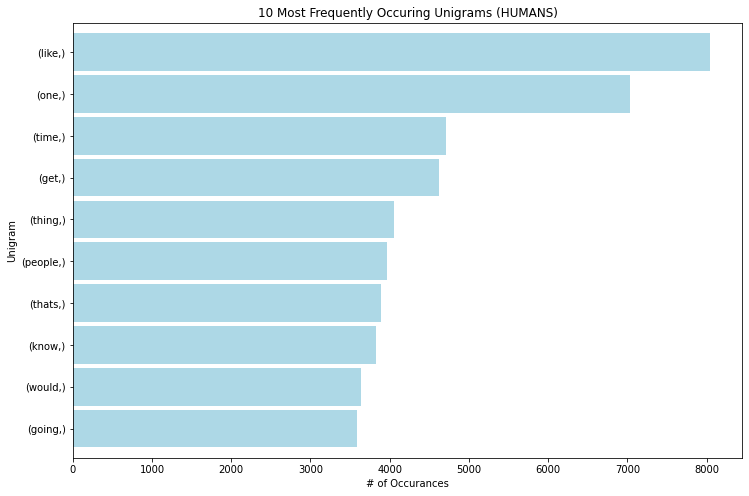

In [23]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (HUMANS)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

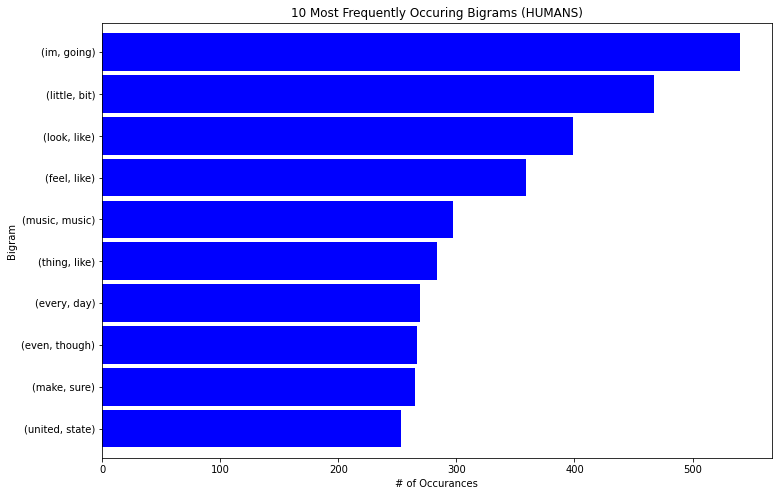

In [24]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

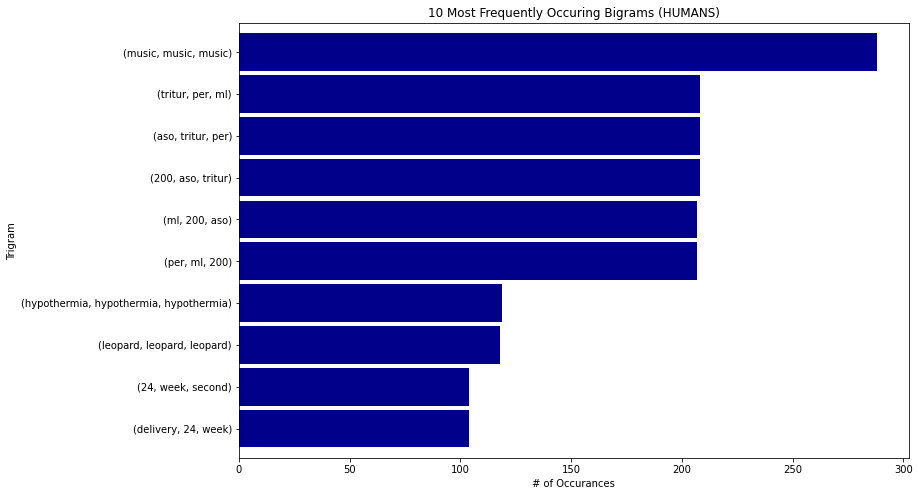

In [25]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (HUMANS)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## Visualizing 'chatgpt words'

In [ ]:
unigram = (pd.Series(nltk.ngrams(chatgpt_words, 1)).value_counts())
bigram = (pd.Series(nltk.ngrams(chatgpt_words, 2)).value_counts())
trigram = (pd.Series(nltk.ngrams(chatgpt_words, 3)).value_counts())

In [ ]:
# create series of top 10 of n-gram
unigrams_series = unigram[:10]
bigrams_series = bigram[:10]
trigrams_series = trigram[:10]

Text(0.5, 0, '# of Occurances')

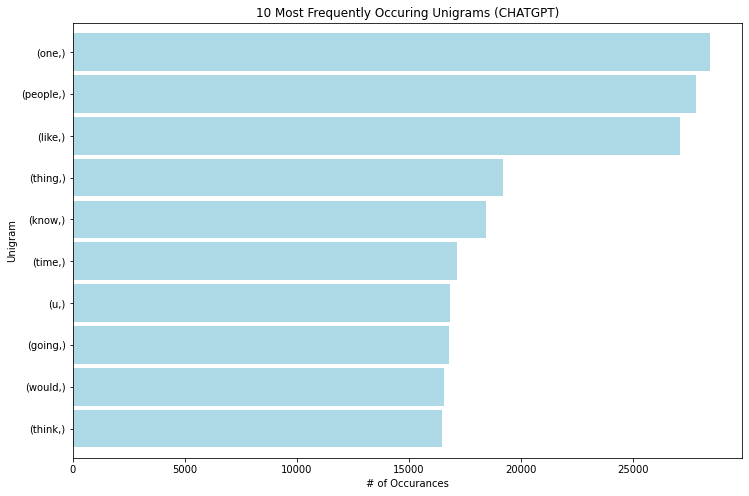

In [ ]:
unigrams_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Unigrams (CHATGPT)')
plt.ylabel('Unigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

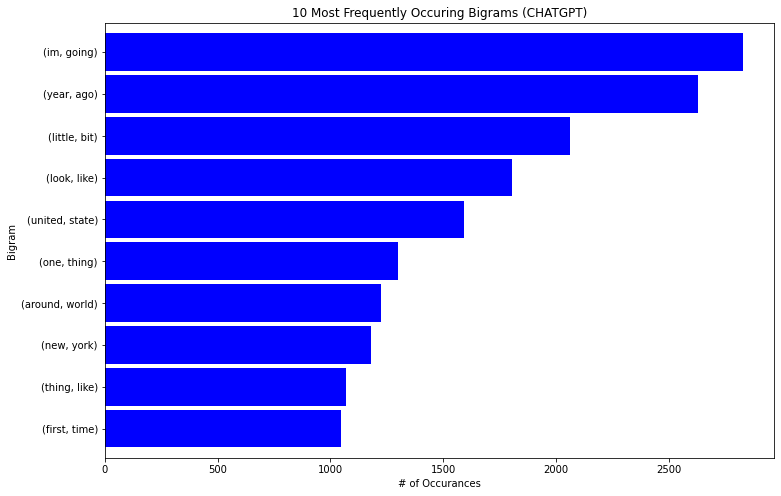

In [ ]:
bigrams_series.sort_values().plot.barh(color='blue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Bigram')
plt.xlabel('# of Occurances')

Text(0.5, 0, '# of Occurances')

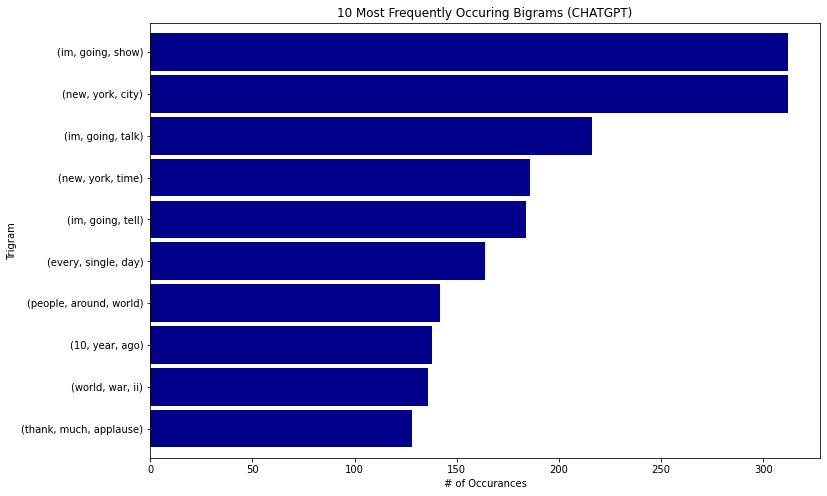

In [ ]:
trigrams_series.sort_values().plot.barh(color='darkblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Bigrams (CHATGPT)')
plt.ylabel('Trigram')
plt.xlabel('# of Occurances')

## It's SVM time (basic words)

### Data Preprocessing

In [30]:
from sklearn import preprocessing

le = preprocessing.LabelEncoder()
le.fit(df.Label)
df['Label'] = le.transform(df.Label)

In [38]:
df["Answer"] = df["Answer"].astype(str)

In [39]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
counter = 0
for text in df["Answer"]:
    
    # Track loop
    counter = counter + 1
    print(counter)

    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]
    
    # Joining
    text = " ".join(text)
    
    cleanedData.append(text)

for i in range(0,5):
    print(cleanedData[i],end="\n\n")

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199
200
201
202
203
204
205
206
207
208
209
210
211
212
213
214
215
216
217
218
219
220
221
222
223
224
225
226
227
228
229
230
231
232
233
234
235
236
237
238
239
240
241
242
243
244
245
246
247
248
249
250
251
252
253
254
255
256
257
258
259
260
261
262
263
264
265
266
267
268
269
270
271
272
273
274
275
276
277


In [40]:
vectorizer = CountVectorizer(max_features=100000)
BOW = vectorizer.fit_transform(cleanedData)

In [41]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(df["Label"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(1460, 49434)
(487, 49434)
(1460,)
(487,)


In [42]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC( verbose=True)
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

[LibSVM]Fitting SVC took 8.07 seconds


In [43]:
predictions = model.predict(x_test)

In [44]:
training_predictions= model.predict(x_train)

In [45]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print("Training Accuracy of model is {}%".format(accuracy_score(y_train,training_predictions) * 100))
print("Testing Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))
print("Precision of model is {}%".format(precision_score(y_test,predictions) * 100))
print("recall of model is {}%".format(recall_score(y_test,predictions) ))
print("f1 of model is {}%".format(f1_score(y_test,predictions) ))
print((confusion_matrix(y_test,predictions) ))

Training Accuracy of model is 92.05479452054794%
Testing Accuracy of model is 84.59958932238193%
Precision of model is 77.35191637630662%
recall of model is 0.9568965517241379%
f1 of model is 0.8554913294797688%
[[190  65]
 [ 10 222]]


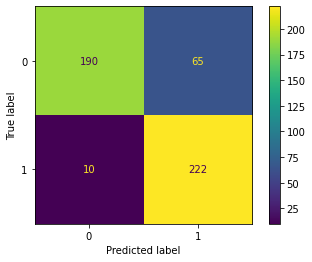

In [46]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=df.Label)
ConfusionMatrixDisplay.from_predictions(y_test,predictions)


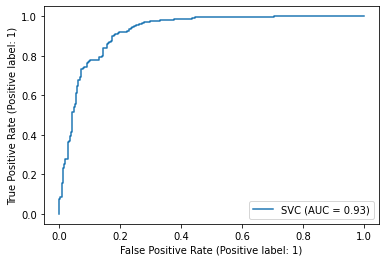

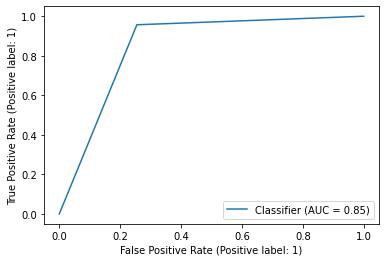

In [47]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, x_test, y_test)
RocCurveDisplay.from_predictions(y_test, predictions)

# Naive Bayes

In [48]:
model = MultinomialNB().fit(x_train, y_train)

In [49]:
y_pred = model.predict(x_test)

In [50]:
a= model.predict(x_train)

In [51]:
print('NB :')
print("Accuracy of model is {}%".format(accuracy_score(y_train,a) * 100))
print("Accuracy of model is {}%".format(accuracy_score(y_test,y_pred) * 100))
print("Precision of model is {}%".format(precision_score(y_test,y_pred) * 100))
print("recall of model is {}".format(recall_score(y_test,y_pred) ))
print("f1 of model is {}%".format(f1_score(y_test,y_pred) ))

NB :
Accuracy of model is 93.4931506849315%
Accuracy of model is 85.42094455852155%
Precision of model is 90.04975124378109%
recall of model is 0.7801724137931034
f1 of model is 0.836027713625866%


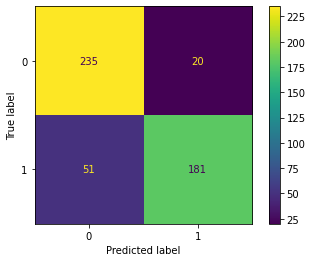

In [52]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
cm = confusion_matrix(y_test, predictions, labels=df.Label)
ConfusionMatrixDisplay.from_predictions(y_test,y_pred)

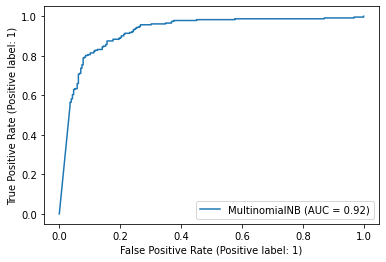

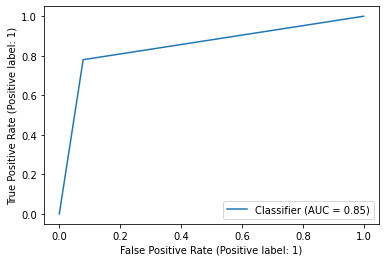

In [53]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, x_test, y_test)
RocCurveDisplay.from_predictions(y_test, y_pred)

# Parts-Of-Speech tagging

## Human POS

In [ ]:
# nltk tagging
human_pos = nltk.pos_tag(human_words)
print(human_pos)

[('left', 'JJ'), ('wing', 'NN'), ('politics', 'NNS'), ('often', 'RB'), ('focus', 'VBP'), ('social', 'JJ'), ('equality', 'NN'), ('right', 'RB'), ('wing', 'VBG'), ('politics', 'NNS'), ('comparison', 'NN'), ('motivated', 'VBN'), ('social', 'JJ'), ('hierarchy', 'NN'), ('left', 'VBD'), ('wing', 'VBG'), ('politics', 'NNS'), ('encompasses', 'VBZ'), ('liberal', 'JJ'), ('idea', 'NN'), ('like', 'IN'), ('right', 'JJ'), ('equality', 'NN'), ('whereas', 'RB'), ('right', 'JJ'), ('leaning', 'VBG'), ('politics', 'NNS'), ('motivated', 'VBD'), ('nationalistic', 'JJ'), ('idea', 'NN'), ('tradition', 'NN'), ('duty', 'NN'), ('generally', 'RB'), ('follow', 'VBP'), ('conservative', 'JJ'), ('school', 'NN'), ('thought', 'VBD'), ('many', 'JJ'), ('subfields', 'NNS'), ('economics', 'NNS'), ('really', 'RB'), ('depends', 'VBZ'), ('keen', 'JJ'), ('getting', 'VBG'), ('started', 'VBD'), ('wish', 'JJ'), ('understand', 'NN'), ('mainstream', 'NN'), ('economist', 'NN'), ('study', 'NN'), ('human', 'JJ'), ('behavior', 'NN'), 

In [ ]:
# extract the pos tags from human_pos
human_pos_tags = []
for pos in human_pos:
  human_pos_tags.append(pos[1])

print(human_pos_tags)

['JJ', 'NN', 'NNS', 'RB', 'VBP', 'JJ', 'NN', 'RB', 'VBG', 'NNS', 'NN', 'VBN', 'JJ', 'NN', 'VBD', 'VBG', 'NNS', 'VBZ', 'JJ', 'NN', 'IN', 'JJ', 'NN', 'RB', 'JJ', 'VBG', 'NNS', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'RB', 'VBP', 'JJ', 'NN', 'VBD', 'JJ', 'NNS', 'NNS', 'RB', 'VBZ', 'JJ', 'VBG', 'VBD', 'JJ', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'MD', 'VB', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'JJ', 'NN', 'NNS', 'RB', 'VBG', 'NN', 'NN', 'RB', 'JJ', 'JJ', 'NN', 'JJ', 'NNS', 'NN', 'MD', 'VB', 'JJ', 'VBG', 'JJ', 'VBG', 'RB', 'JJ', 'NN', 'NN', 'RB', 'JJ', 'NN', 'RB', 'JJ', 'NN', 'NN', 'MD', 'VB', 'JJ', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'VBG', 'NN', 'VBD', 'VBG', 'NN', 'NNS', 'MD', 'VB', 'VBG', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'RB', 'RB', 'JJ', 'NN', 'NN', 'JJ', 'NNS', 'NN', 'RB', 'NN', 'NN', 'NN', 'RB', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'RB', 'JJ', 'NN', 'JJ', 'NNS', 'JJ', 'MD', 'VBN', 'VB', 'NN', 'NN', 'NN', 'NNS', 'MD', 'VB', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBP', 'JJ', 'JJ', 'NN', 'VBD', 'JJ', 'NN', 'NN

## Visualizing 'human Part-Of-Speech Tags'

In [ ]:
tags = (pd.Series(nltk.ngrams(human_pos_tags, 1)).value_counts())

In [ ]:
# create series of top 10
tags_series = tags[:10]

Text(0.5, 0, '# of Occurances')

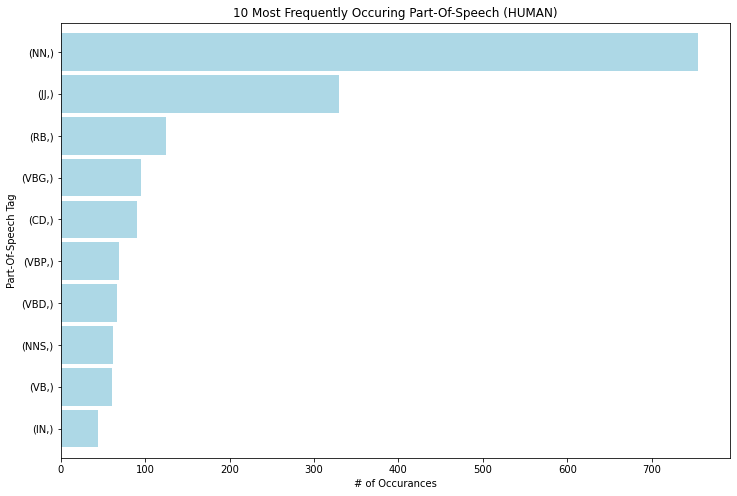

In [ ]:
tags_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Part-Of-Speech (HUMAN)')
plt.ylabel('Part-Of-Speech Tag')
plt.xlabel('# of Occurances')

## ChatGPT POS

In [ ]:
# nltk tagging
chatgpt_pos = nltk.pos_tag(chatgpt_words)
print(chatgpt_pos)

[('leftwing', 'VBG'), ('politics', 'NNS'), ('typically', 'RB'), ('involves', 'VBZ'), ('support', 'NN'), ('policy', 'NN'), ('prioritize', 'VBP'), ('need', 'NN'), ('welfare', 'NN'), ('marginalized', 'VBN'), ('oppressed', 'VBN'), ('group', 'NN'), ('worker', 'NN'), ('minority', 'NN'), ('poor', 'JJ'), ('leftwing', 'VBG'), ('ideology', 'NN'), ('often', 'RB'), ('advocate', 'JJ'), ('greater', 'JJR'), ('government', 'NN'), ('intervention', 'NN'), ('economy', 'NN'), ('progressive', 'JJ'), ('taxation', 'NN'), ('social', 'JJ'), ('program', 'NN'), ('ensure', 'VB'), ('equal', 'JJ'), ('distribution', 'NN'), ('wealth', 'NN'), ('opportunity', 'NN'), ('also', 'RB'), ('tend', 'VBP'), ('supportive', 'JJ'), ('environmental', 'JJ'), ('protection', 'NN'), ('civil', 'JJ'), ('liberty', 'NN'), ('international', 'JJ'), ('cooperation', 'NN'), ('rightwing', 'VBG'), ('politics', 'NNS'), ('hand', 'NN'), ('generally', 'RB'), ('prioritizes', 'VBZ'), ('need', 'JJ'), ('interest', 'NN'), ('traditional', 'JJ'), ('societal

In [ ]:
# extract the pos tags from human_pos
chatgpt_pos_tags = []
for pos in chatgpt_pos:
  chatgpt_pos_tags.append(pos[1])

print(chatgpt_pos_tags)

['VBG', 'NNS', 'RB', 'VBZ', 'NN', 'NN', 'VBP', 'NN', 'NN', 'VBN', 'VBN', 'NN', 'NN', 'NN', 'JJ', 'VBG', 'NN', 'RB', 'JJ', 'JJR', 'NN', 'NN', 'NN', 'JJ', 'NN', 'JJ', 'NN', 'VB', 'JJ', 'NN', 'NN', 'NN', 'RB', 'VBP', 'JJ', 'JJ', 'NN', 'JJ', 'NN', 'JJ', 'NN', 'VBG', 'NNS', 'NN', 'RB', 'VBZ', 'JJ', 'NN', 'JJ', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'JJ', 'VBG', 'NN', 'VBP', 'NN', 'JJ', 'NN', 'NN', 'NN', 'JJR', 'NN', 'JJR', 'JJ', 'NN', 'RB', 'VBP', 'JJ', 'JJ', 'JJ', 'NN', 'NN', 'NN', 'JJ', 'JJ', 'NN', 'JJ', 'VBG', 'NNS', 'VBN', 'NN', 'NN', 'JJ', 'NN', 'NN', 'VBN', 'NN', 'VBG', 'NNS', 'NN', 'NN', 'JJ', 'NN', 'JJR', 'NN', 'NN', 'VBD', 'NN', 'NNS', 'VBN', 'JJ', 'NN', 'NN', 'NN', 'IN', 'NN', 'VBN', 'CD', 'VBN', 'JJ', 'JJ', 'NN', 'NNS', 'RB', 'RB', 'VBN', 'NN', 'JJ', 'NNS', 'VBD', 'RB', 'VBN', 'CD', 'VBD', 'CD', 'JJ', 'NNS', 'NN', 'RB', 'CD', 'JJ', 'JJ', 'NN', 'JJ', 'NN', 'NN', 'NN', 'NN', 'NN', 'NN', 'NNS', 'VBN', 'CD', 'JJ', 'JJ', 'NN', 'VBZ', 'JJ', 'NN', 'NN', 'JJ', 'NN', 'NN', 'RB', 'VBN', 'CD', 'JJ',

## Visualizing 'ChatGPT Part-Of-Speech Tags'

In [ ]:
tags = (pd.Series(nltk.ngrams(chatgpt_pos_tags, 1)).value_counts())

In [ ]:
# create series of top 10
tags_series = tags[:10]

Text(0.5, 0, '# of Occurances')

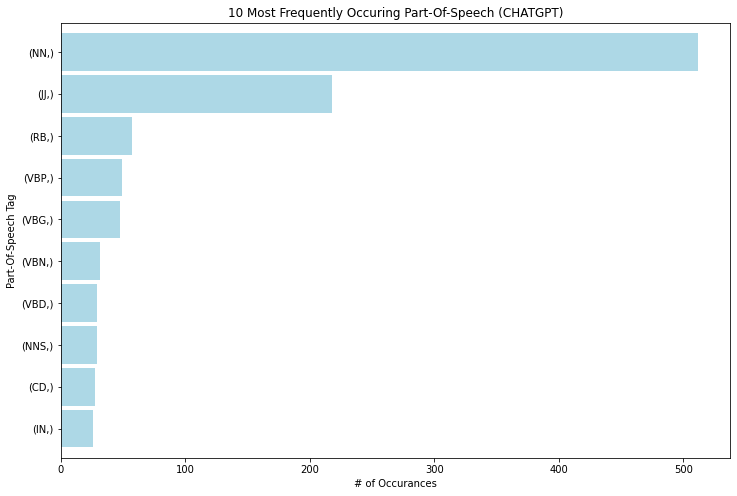

In [ ]:
tags_series.sort_values().plot.barh(color='lightblue', width=.9, figsize=(12, 8))
plt.title('10 Most Frequently Occuring Part-Of-Speech (CHATGPT)')
plt.ylabel('Part-Of-Speech Tag')
plt.xlabel('# of Occurances')

## It's SVM time

### Data Preprocessing (POS)

In [ ]:
cleanedData = []

lemma = WordNetLemmatizer()
swords = stopwords.words("english")
for text in df["Text"]:
    
    # Cleaning links
    text = re.sub(r'http\S+', '', text)
    
    # Cleaning everything except alphabetical and numerical characters
    text = re.sub("[^a-zA-Z0-9]"," ",text)
    
    # Tokenizing and lemmatizing
    text = nltk.word_tokenize(text.lower())
    text = [lemma.lemmatize(word) for word in text]
    
    # Removing stopwords
    text = [word for word in text if word not in swords]

    temptxt = ""
    for word in text:
      temp = nltk.pos_tag([word])
      # print(temp[0][1])
      temptxt = temptxt + temp[0][1] + " "
    
    # Joining
    text = "".join(temptxt)
    
    cleanedData.append(text)

print(cleanedData)
# for i in range(0,5):
#     print(cleanedData[i],end="\n\n")

['NN VBG NNS RB NNS NN NN NN NN NN VBN VBN NN NN NN JJ NN VBG NN RB NN JJR NN NN NN NN NN JJ NN VB JJ NN NN NN RB NN NN JJ NN JJ NN JJ NN NN VBG NNS NN RB NNS NN NN JJ NN JJ NN NN NN NN NN VBG NN NN NN JJ NN NN NN JJR NN JJR JJ NN RB NN NN JJ JJ NN NN NN JJ JJ NN NN NN VBG NNS VBN NN NN JJ NN NN VBN NN NN VBG NNS NN NN JJ NN JJR NN NN ', 'NN VBG NNS RB NN JJ NN NN VBG NNS NN VBN JJ NN NN VBG NNS NNS JJ NN IN NN NN NNS NN VBG NNS VBN JJ NN NN NN RB VB JJ NN NN ', 'JJ NN NN NNS RB NNS NN VBG VBN NN NN NN NN NN NN NN MD NN NN NN NN NN NN NN NN NN NN RB VBG NN NN RB VBN JJ NN JJ NNS NN MD NN JJ VBG NN VBG NN VB NN NN RB JJ NN RB NN NN NN MD NN JJ JJ NN NN NN NN VBG NN JJ VBG NN NNS MD NN VBG JJ NN JJ NN NN NN NN RB NN NN NN NN JJ NNS NN RB NN NN NN RB NN NN CD NN NN NN JJ NN JJ NNS JJ MD VBN NN NN NN NN NNS MD NN NN NN NN NN NNS NN NN NN NN NN NN NN NN NN NN JJ NN NN NN RB NN NN NN JJ JJ NN MD IN NN NN NNS NN ', 'MD NN NN NNS VBN JJ NN NN NN NN NN VBN CD VBN RB JJ NN NNS RB RB NN NN NN NNS

In [ ]:
left wing politics typically involves support policy prioritize need welfare marginalized oppressed group worker minority poor left wing ideology often advocate greater government intervention economy progressive taxation social program ensure equal distribution wealth opportunity also tend supportive environmental protection civil liberty international cooperation right wing politics hand generally prioritizes need interest traditional societal economic elite business owner wealthy right wing ideology tend advocate limited government intervention economy lower tax smaller social program also tend supportive strong national defense law order traditional social value summary left wing politics characterized emphasis equality social justice protection marginalized group right wing politics focus tradition personal responsibility smaller role government

left wing politics often focus social equality right wing politics comparison motivated social hierarchy left wing politics encompasses liberal idea like right equality whereas right leaning politics motivated nationalistic idea tradition duty generally follow conservative school thought

many sub field economics really depends keen getting started wish understand mainstream economist study human behavior could try logic life tim harford armchair economist steven e landsburg already understanding rationality paradigm typically employed economic analysis behavioural economics book might offer new contrasting insight thinking fast slow daniel kahneman predictably irrational dan ariely nudge richard thaler ca sunstein interested economic history wish delve deeper pioneering idea advanced founding father economics would recommend following new idea dead economist todd g buchholz worldly philosopher robert l heilbroner interested economics inequality specifically income wealth distribution certainly pick capital 21st century thomas piketty curious country rich others poor could done tackle poverty e development economics could turn nation fail daron acemoglu james robinson gun germ steel jared diamond end poverty jeffrey sachs white man burden william easterly list book offer exhaustive good start would like pick quality economics book

must read book economics considered classic field wealth nation adam smith published 1776 considered first modern work economics still widely read today principle economics alfred marshall published 1890 considered one influential economics text late 19th early 20th century general theory employment interest money john maynard keynes published 1936 revolutionized macroeconomic thought continues influential today capital twenty first century thomas piketty published 2014 comprehensive study income wealth inequality cause nudge improving decision health wealth happiness richard thaler ca sunstein published 2008 popularized concept behavioral economics implication policy making book provide broad overview field economics evolution time considered essential reading anyone interested subject

money started business say make world better place solve customer problem reality money easily biggest driver plenty evidence give one ha businessperson history sold business enough comfortably retire choice carried working full time business passionate problem business wa solving passion business go instant longer financially rewarded action speak much louder word


In [ ]:
vectorizer = CountVectorizer(max_features=10000)
BOW = vectorizer.fit_transform(cleanedData)

In [ ]:
from sklearn.model_selection import train_test_split
x_train,x_test,y_train,y_test = train_test_split(BOW,np.asarray(df["Class"]))

print(x_train.shape)
print(x_test.shape)
print(y_train.shape)
print(y_test.shape)

(22, 17)
(8, 17)
(22,)
(8,)


In [ ]:
from sklearn.svm import SVC
start_time = time.time()

model = SVC( verbose=True)
model.fit(x_train,y_train)

end_time = time.time()
process_time = round(end_time-start_time,2)
print("Fitting SVC took {} seconds".format(process_time))

[LibSVM]Fitting SVC took 0.01 seconds


In [ ]:
predictions = model.predict(x_test)

In [ ]:
training_predictions= model.predict(x_train)

In [ ]:
from sklearn.metrics import accuracy_score,confusion_matrix,recall_score,precision_score
from sklearn.metrics import classification_report
from sklearn.metrics import f1_score

print("Accuracy of model is {}%".format(accuracy_score(y_train,training_predictions) * 100))
print("Accuracy of model is {}%".format(accuracy_score(y_test,predictions) * 100))
print("Precision of model is {}%".format(precision_score(y_test,predictions) * 100))
print("recall of model is {}%".format(recall_score(y_test,predictions) ))
print("f1 of model is {}%".format(f1_score(y_test,predictions) ))
print((confusion_matrix(y_test,predictions) ))

Accuracy of model is 77.27272727272727%
Accuracy of model is 62.5%
Precision of model is 100.0%
recall of model is 0.4%
f1 of model is 0.5714285714285715%
[[3 0]
 [3 2]]


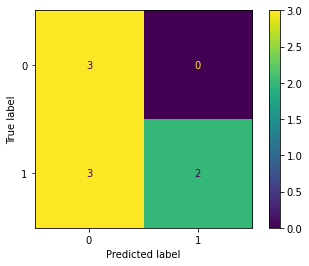

In [ ]:
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_test, predictions, labels=df.Class)
ConfusionMatrixDisplay.from_predictions(y_test,predictions)


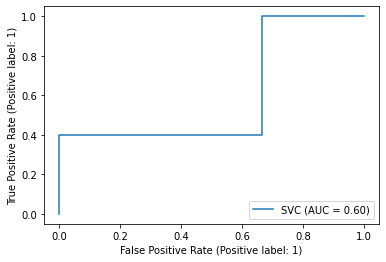

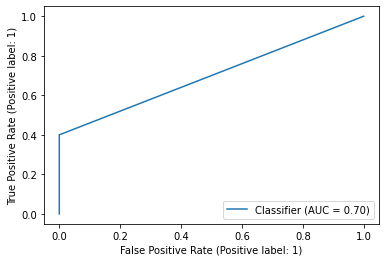

In [ ]:
from sklearn.metrics import roc_curve
from sklearn.metrics import RocCurveDisplay
RocCurveDisplay.from_estimator(model, x_test, y_test)
RocCurveDisplay.from_predictions(y_test, predictions)

# WordNet to Roget's Thesaurus

In [ ]:
# clone https://github.com/evanmiltenburg/roget.git
! git clone https://github.com/evanmiltenburg/roget.git

Cloning into 'roget'...
remote: Enumerating objects: 1051, done.
remote: Total 1051 (delta 0), reused 0 (delta 0), pack-reused 1051
Receiving objects: 100% (1051/1051), 861.47 KiB | 6.15 MiB/s, done.
Resolving deltas: 100% (21/21), done.


In [ ]:
%cd /content/

/content


In [ ]:
print(human_words)

['left', 'wing', 'politics', 'often', 'focus', 'social', 'equality', 'right', 'wing', 'politics', 'comparison', 'motivated', 'social', 'hierarchy', 'left', 'wing', 'politics', 'encompasses', 'liberal', 'idea', 'like', 'right', 'equality', 'whereas', 'right', 'leaning', 'politics', 'motivated', 'nationalistic', 'idea', 'tradition', 'duty', 'generally', 'follow', 'conservative', 'school', 'thought', 'many', 'subfields', 'economics', 'really', 'depends', 'keen', 'getting', 'started', 'wish', 'understand', 'mainstream', 'economist', 'study', 'human', 'behavior', 'could', 'try', 'logic', 'life', 'tim', 'harford', 'armchair', 'economist', 'steven', 'e', 'landsburg', 'already', 'understanding', 'rationality', 'paradigm', 'typically', 'employed', 'economic', 'analysis', 'behavioural', 'economics', 'book', 'might', 'offer', 'new', 'contrasting', 'insight', 'thinking', 'fast', 'slow', 'daniel', 'kahneman', 'predictably', 'irrational', 'dan', 'ariely', 'nudge', 'richard', 'thaler', 'ca', 'sunstei

In [ ]:
from nltk.corpus import wordnet
syn = wordnet.synsets('left')

for thing in syn:
  print(thing.pos())
print(syn)

n
n
n
n
n
v
v
v
v
v
v
v
v
v
v
v
v
v
v
a
s
s
a
r
[Synset('left.n.01'), Synset('left.n.02'), Synset('left.n.03'), Synset('left_field.n.01'), Synset('left.n.05'), Synset('leave.v.01'), Synset('leave.v.02'), Synset('leave.v.03'), Synset('leave.v.04'), Synset('exit.v.01'), Synset('leave.v.06'), Synset('leave.v.07'), Synset('leave.v.08'), Synset('entrust.v.02'), Synset('bequeath.v.01'), Synset('leave.v.11'), Synset('leave.v.12'), Synset('impart.v.01'), Synset('forget.v.04'), Synset('left.a.01'), Synset('leftover.s.01'), Synset('left.s.03'), Synset('left.a.04'), Synset('left.r.01')]


In [ ]:
!python /content/roget/roget.py

set()


In [ ]:
!git clone https://github.com/MoserMichael/cstuff.git

Cloning into 'cstuff'...
remote: Enumerating objects: 16920, done.
remote: Counting objects: 100% (196/196), done.
remote: Compressing objects: 100% (148/148), done.
remote: Total 16920 (delta 83), reused 58 (delta 30), pack-reused 16724
Receiving objects: 100% (16920/16920), 29.96 MiB | 19.26 MiB/s, done.
Resolving deltas: 100% (12406/12406), done.
